In [ ]:
import os
import re
import math
import argparse
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 스타일 설정 (한글 폰트 설정이 필요하다면 별도 추가 필요, 여기선 기본값)
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# -----------------------
# [설정] 실행 파라미터 (argparse 대체)
# -----------------------
class Config:
    LOG_DIR = "./logs/frenet"          # 로그 파일이 위치한 경로 (WSL 경로)
    MIN_LAP_TIME = 20.0         # 첫 랩 완주로 인정할 최소 시간 (초)
    GOAL_RADIUS = 1.0           # 시작점으로 돌아왔다고 볼 거리 임계값 (m)
    MAPS = ["Spielberg", "hairpin_combo"] # 합산할 맵 이름 리스트

config = Config()

# 로그 디렉토리 확인
if not os.path.exists(config.LOG_DIR):
    print(f"경고: '{config.LOG_DIR}' 경로가 존재하지 않습니다. 경로를 확인해주세요.")
    os.makedirs(config.LOG_DIR, exist_ok=True) # 테스트를 위해 생성 (실제 파일 넣어주셔야 함)

In [ ]:
import os
import re
import math
import glob
import pandas as pd

# =========================================================
# 1) 파일명 파싱 (기존 코드 동일)
# =========================================================
FNAME_PATTERN = re.compile(
    r'(?P<map>.+)_SPD(?P<spd>[\d.]+)_TGT(?P<tgt>[\d.]+)_ACC(?P<acc>[\d.]+)_CRV(?P<crv>[\d.]+)_FRENET_(?P<stamp>\d+)_(?P<result>[A-Z]+)_dur_(?P<dur>[\d.]+)s\.csv'
)

def parse_filename(fname: str):
    m = FNAME_PATTERN.match(fname)
    if not m:
        return None
    d = m.groupdict()
    # 숫자형 변환
    for k in ["spd", "tgt", "acc", "crv", "dur"]:
        d[k] = float(d[k])
    # 타임스탬프는 정수형으로 변환 (비교를 위해)
    d['stamp'] = int(d['stamp'])
    return d

# =========================================================
# 2) CSV에서 수치 구간만 추출 (기존 코드 동일)
# =========================================================
def _is_float_str(s):
    try:
        float(s)
        return True
    except Exception:
        return False

def extract_numeric(df: pd.DataFrame) -> pd.DataFrame:
    # 't' 컬럼이 숫자이거나 숫자로 변환 가능한 행만 추출
    mask = df["t"].apply(
        lambda v: (
            isinstance(v, (int, float))
            or (isinstance(v, str) and _is_float_str(v))
        )
    )
    num = df[mask].copy()
    if num.empty:
        return num

    for col in ["t", "x", "y"]:
        num[col] = num[col].astype(float)
    return num

# =========================================================
# 3) 첫 랩 완주 시점 추정 (기존 코드 동일)
# =========================================================
def calc_first_lap_time(num_df: pd.DataFrame, min_lap_time: float = 10.0, goal_radius: float = 1.0):
    if num_df.empty:
        return None
    x0, y0 = num_df["x"].iloc[0], num_df["y"].iloc[0]
    for _, row in num_df.iterrows():
        t = row["t"]
        if t < min_lap_time:
            continue
        d = math.hypot(row["x"] - x0, row["y"] - y0)
        if d < goal_radius:
            return t
    return None

# =========================================================
# 4) 개별 파일 분석 (기존 코드 동일)
# =========================================================
def analyze_run(path: str, min_lap_time: float = 20.0, goal_radius: float = 1.0) -> dict:
    fname = os.path.basename(path)
    meta = parse_filename(fname)
    if meta is None:
        raise ValueError(f"파일명 형식이 예상과 다름: {fname}")

    df = pd.read_csv(path)

    # 요약 정보 파싱 (Finish Reason, Duration)
    finish_row = df.loc[df["t"] == "Finish Reason", "x"]
    finish_reason = finish_row.iloc[0] if not finish_row.empty else meta["result"]

    duration_row = df.loc[df["t"] == "Duration (s)", "x"]
    duration_summary = float(duration_row.iloc[0]) if not duration_row.empty else None

    # 수치 데이터 추출
    num = extract_numeric(df)
    duration_numeric = num["t"].iloc[-1] if not num.empty else 0.0

    info = {
        **meta,
        "finish_reason": finish_reason,
        "n_rows": len(df),
        "n_numeric": len(num),
        "duration_numeric": duration_numeric,
        "duration_summary": duration_summary,
        "abort_reason": None,
        "effective_time": None,
        "needs_rerun": False,
        "file_path": path
    }

    result = meta["result"]

    if result == "GOAL":
        if duration_summary is not None:
            info["effective_time"] = duration_summary
        else:
            info["effective_time"] = duration_numeric
    elif result == "CRASH":
        info["abort_reason"] = "CRASH"
        info["needs_rerun"] = False
    elif result == "STUCK":
        info["abort_reason"] = "STUCK"
        info["needs_rerun"] = False
    elif result == "ABORT":
        if num.empty:
            info["abort_reason"] = "NO_MOTION"
            info["needs_rerun"] = True
        else:
            lap_time = calc_first_lap_time(num, min_lap_time, goal_radius)
            if lap_time is None:
                info["abort_reason"] = "EARLY_ABORT_NO_LAP"
                info["needs_rerun"] = True
            else:
                info["abort_reason"] = "MULTI_LAP_OR_MANUAL_ABORT_AFTER_LAP"
                info["effective_time"] = lap_time
                info["needs_rerun"] = False
    else:
        info["abort_reason"] = f"UNKNOWN_RESULT_{result}"
        info["needs_rerun"] = True

    return info

# =========================================================
# [NEW] 5) 최신 파일 필터링 및 실행 로직
# =========================================================

def get_latest_log_files(log_dir: str):
    """
    디렉토리 내의 모든 csv 파일을 검사하여,
    (Map, Spd, Tgt, Acc, Crv) 조합별로 가장 최신 Timestamp를 가진 파일만 리스트로 반환합니다.
    """
    all_files = glob.glob(os.path.join(log_dir, "*.csv"))
    
    # Key: (map, spd, tgt, acc, crv) 튜플
    # Value: (timestamp, filepath)
    latest_files_map = {}

    print(f"[{log_dir}] 폴더에서 파일 검색 중...")
    
    for fpath in all_files:
        fname = os.path.basename(fpath)
        meta = parse_filename(fname)
        
        # 파일명 패턴이 맞지 않으면 스킵
        if meta is None:
            continue
            
        # 고유 식별 키 생성 (파라미터 조합)
        # float 비교 오차를 줄이기 위해 문자열 포맷팅을 하거나 그대로 사용
        # 여기서는 meta에 이미 float로 변환된 값이 들어있으므로 튜플로 사용
        key = (meta['map'], meta['spd'], meta['tgt'], meta['acc'], meta['crv'])
        stamp = meta['stamp']
        
        # 맵에 없거나, 현재 파일이 더 최신이면 업데이트
        if key not in latest_files_map:
            latest_files_map[key] = (stamp, fpath)
        else:
            existing_stamp, _ = latest_files_map[key]
            if stamp > existing_stamp:
                latest_files_map[key] = (stamp, fpath)
    
    # 최종적으로 선택된 파일 경로들만 추출
    selected_files = [val[1] for val in latest_files_map.values()]
    print(f"총 {len(all_files)}개 파일 중 최신 파일 {len(selected_files)}개를 선별했습니다.")
    
    return selected_files

# =========================================================
# 메인 실행부
# =========================================================

# 로그 파일이 위치한 디렉토리 설정
LOG_DIR = "/logs/frenet"  # 실제 로그 폴더 경로로 변경하세요

# 1. 최신 파일 목록 가져오기 (재실험 결과 포함, 중복 파라미터는 최신으로 덮어씀)
target_files = get_latest_log_files(LOG_DIR)

# 2. 분석 실행
results_list = []
for fpath in target_files:
    try:
        # analyze_run 호출
        run_info = analyze_run(fpath, min_lap_time=10.0, goal_radius=2.0)
        results_list.append(run_info)
    except Exception as e:
        print(f"Error processing {os.path.basename(fpath)}: {e}")

# 3. 데이터프레임 변환
df_results = pd.DataFrame(results_list)

# 4. 결과 확인
if not df_results.empty:
    print("\n==== 분석 완료 데이터 (상위 5개) ====")
    # 보기 좋게 정렬 (Map -> Spd -> Result)
    df_results = df_results.sort_values(by=['map', 'spd', 'tgt', 'acc', 'crv'])
    
    # 필요한 컬럼만 출력해서 확인
    cols = ['map', 'spd', 'tgt', 'acc', 'crv', 'result', 'effective_time', 'stamp']
    print(df_results[cols].head())
    
    print(f"\n총 분석된 케이스 수: {len(df_results)}")
else:
    print("분석할 유효한 데이터가 없습니다.")

# 이 df_results를 가지고 기존의 find_best_weights_df 함수 등을 호출하면 됩니다.

[/logs/frenet] 폴더에서 파일 검색 중...
총 0개 파일 중 최신 파일 0개를 선별했습니다.
분석할 유효한 데이터가 없습니다.


In [ ]:
# -----------------------
# 로직 실행
# -----------------------
analyses = []
log_files = [f for f in os.listdir(config.LOG_DIR) if f.endswith(".csv") and "FRENET" in f]

print(f"총 {len(log_files)}개의 로그 파일을 발견했습니다.")

for fname in log_files:
    path = os.path.join(config.LOG_DIR, fname)
    try:
        info = analyze_run(
            path,
            min_lap_time=config.MIN_LAP_TIME,
            goal_radius=config.GOAL_RADIUS,
        )
        analyses.append(info)
    except Exception as e:
        print(f"[WARN] {fname} 분석 실패: {e}")

# 데이터프레임으로 변환 (분석 용이성을 위해)
df_results = pd.DataFrame(analyses)

if df_results.empty:
    print("분석할 데이터가 없습니다.")
else:
    print("분석 완료! 상위 5개 데이터 확인:")
    display(df_results.head())

총 183개의 로그 파일을 발견했습니다.
분석 완료! 상위 5개 데이터 확인:


,map,spd,tgt,acc,crv,stamp,result,dur,finish_reason,n_rows,n_numeric,duration_numeric,duration_summary,abort_reason,effective_time,needs_rerun,file_path
0,Spielberg,6.0,5.2,6.0,0.95,1764828329,ABORT,0.00,MANUAL_ABORT (Force Quit),23496,23480,94.7032,0.00,MULTI_LAP_OR_MANUAL_ABORT_AFTER_LAP,79.3709,False,./logs/frenet\Spielberg_SPD6.0_TGT5.2_ACC6.0_C...
1,hairpin_combo,6.5,5.2,6.0,0.95,1764839781,CRASH,25.09,COLLISION DETECTED,6241,6225,25.0889,25.09,CRASH,NaN,False,./logs/frenet\hairpin_combo_SPD6.5_TGT5.2_ACC6...
2,hairpin_combo,6.0,4.6,5.0,1.00,1764836345,ABORT,93.02,MANUAL_ABORT (Force Quit),16,0,0.0000,93.02,NO_MOTION,NaN,True,./logs/frenet\hairpin_combo_SPD6.0_TGT4.6_ACC5...
3,Spielberg,6.0,5.2,5.0,0.95,1764840714,GOAL,76.77,GOAL REACHED,19150,19134,76.7684,76.77,None,76.7700,False,./logs/frenet\Spielberg_SPD6.0_TGT5.2_ACC5.0_C...
4,hairpin_combo,5.5,5.2,6.0,0.90,1764836130,CRASH,43.75,COLLISION DETECTED,10872,10856,43.7445,43.75,CRASH,NaN,False,./logs/frenet\hairpin_combo_SPD5.5_TGT5.2_ACC6...


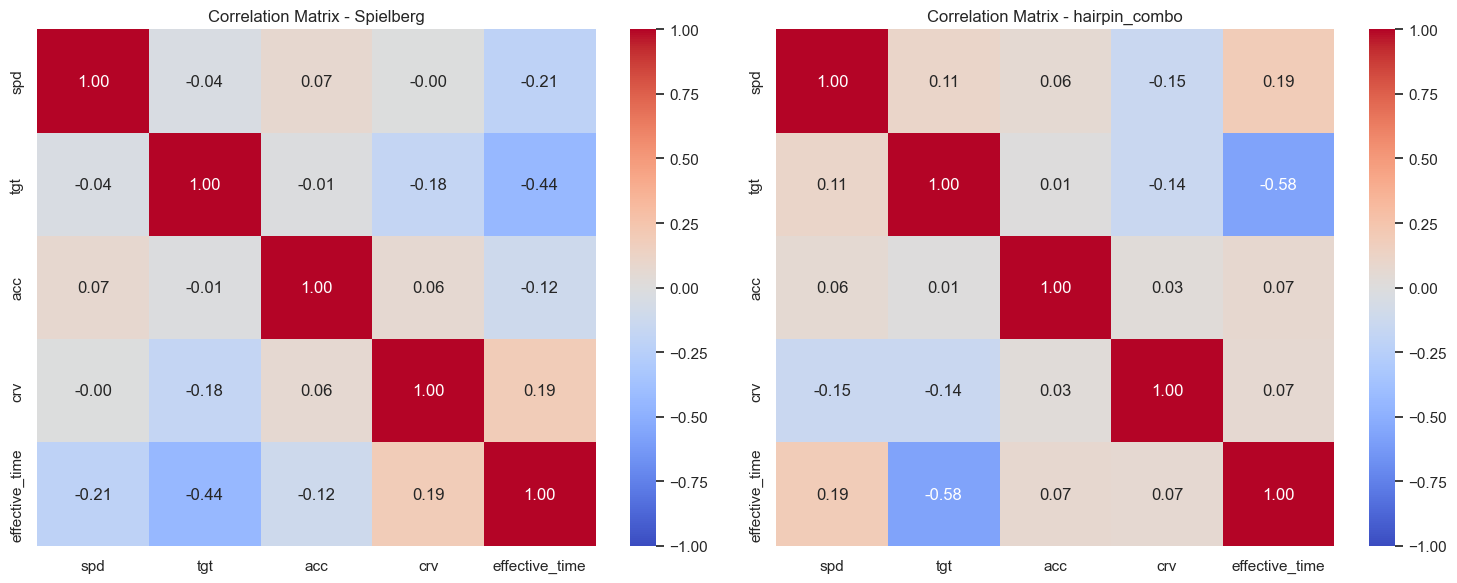

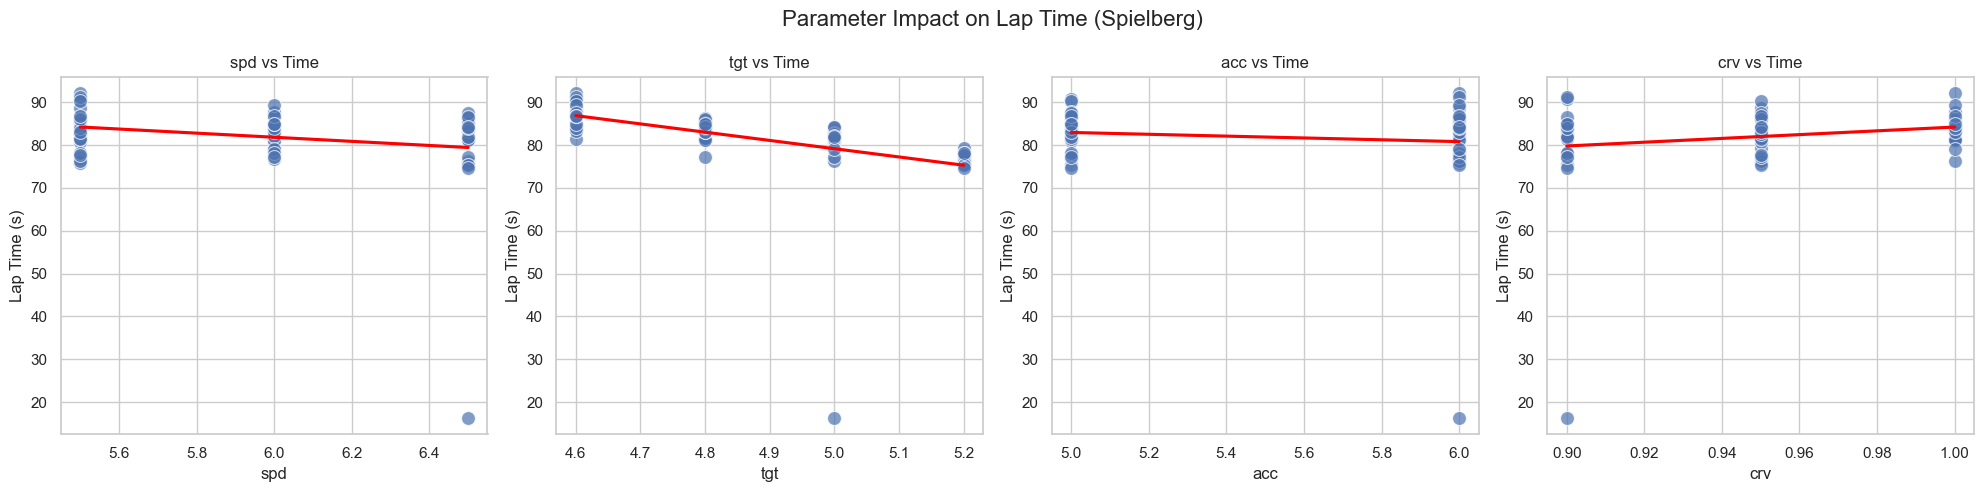

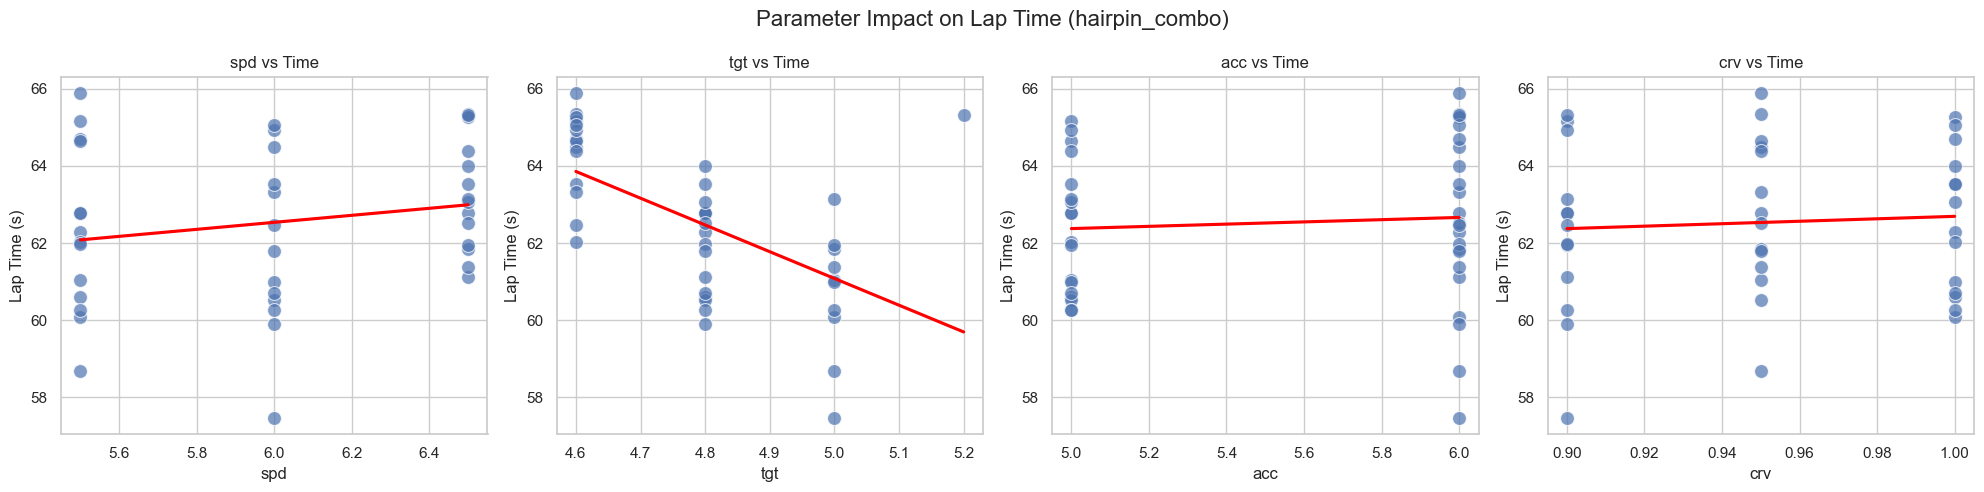

In [ ]:
# 각 파라미터가 랩타임에 미치는 영향을 산점도로 시각화
if not df_results.empty:
    valid_df = df_results[df_results['effective_time'].notnull()]
    
    params = ['spd', 'tgt', 'acc', 'crv']
    
    for map_name in valid_df['map'].unique():
        map_df = valid_df[valid_df['map'] == map_name]
        
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        fig.suptitle(f"Parameter Impact on Lap Time ({map_name})", fontsize=16)
        
        for i, param in enumerate(params):
            sns.scatterplot(data=map_df, x=param, y='effective_time', ax=axes[i], s=100, alpha=0.7)
            
            # 추세선 추가 (데이터가 2개 이상일 때)
            if len(map_df) > 1:
                sns.regplot(data=map_df, x=param, y='effective_time', ax=axes[i], scatter=False, color='red', ci=None)
                
            axes[i].set_title(f"{param} vs Time")
            axes[i].set_ylabel("Lap Time (s)")
            
        plt.tight_layout()
        plt.show()

최고 기록 파라미터 분석: SPD=5.5, TGT=5.0, ACC=6.0, CRV=1.0
분석할 로그 파일: ./logs/frenet\Spielberg_SPD5.5_TGT5.0_ACC6.0_CRV1.00_FRENET_1764824534_GOAL_dur_76.35s.csv


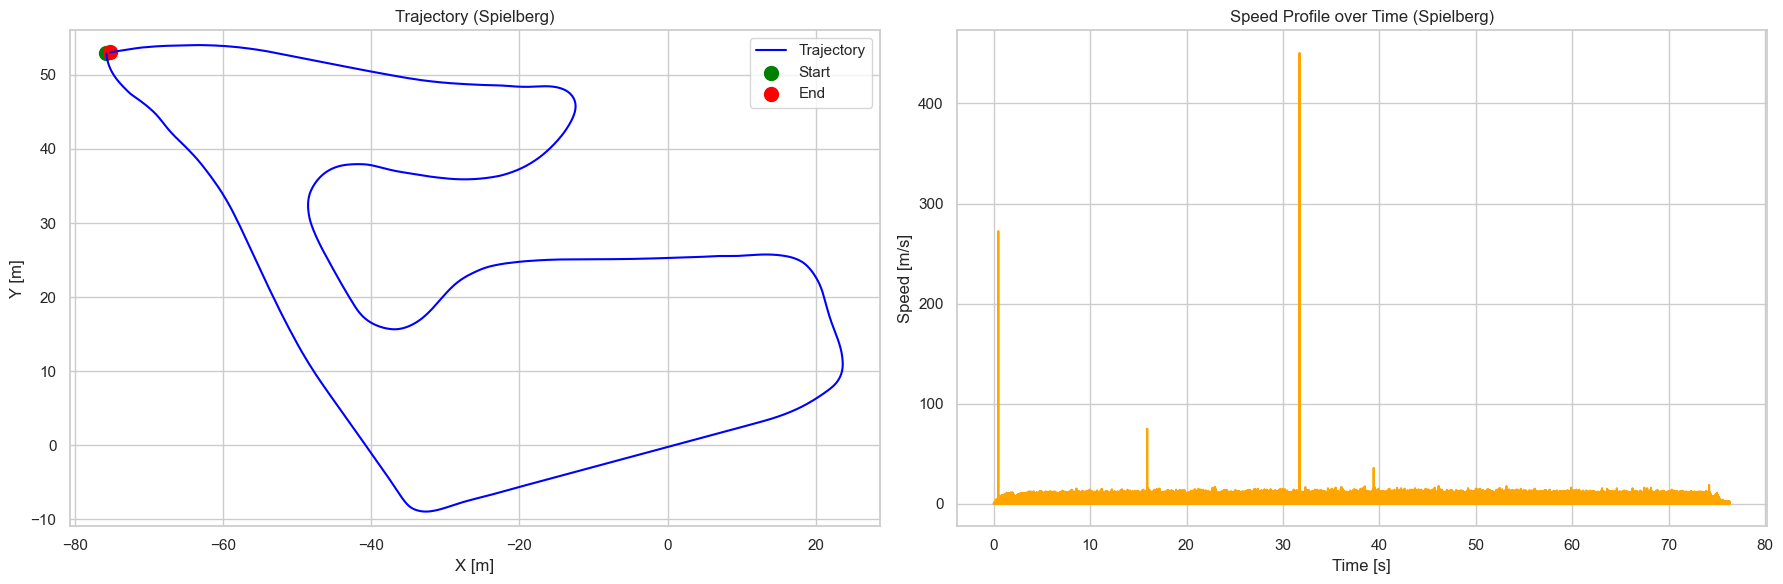

In [ ]:
if len(best_results) > 0:
    # 가장 성적이 좋은 파라미터 조합 가져오기
    best_param = best_results.iloc[0].name # (spd, tgt, acc, crv) tuple
    print(f"최고 기록 파라미터 분석: SPD={best_param[0]}, TGT={best_param[1]}, ACC={best_param[2]}, CRV={best_param[3]}")
    
    # 해당 파라미터의 로그 파일 경로 찾기 (첫 번째 맵 기준)
    target_map = config.MAPS[0]
    best_run_row = df_results[
        (df_results['spd'] == best_param[0]) & 
        (df_results['tgt'] == best_param[1]) & 
        (df_results['acc'] == best_param[2]) & 
        (df_results['crv'] == best_param[3]) &
        (df_results['map'] == target_map)
    ].iloc[0]
    
    best_log_path = best_run_row['file_path']
    print(f"분석할 로그 파일: {best_log_path}")
    
    # 로그 로딩
    run_df = pd.read_csv(best_log_path)
    run_numeric = extract_numeric(run_df)
    
    # --- 시각화 ---
    plt.figure(figsize=(18, 6))
    
    # 1. 주행 경로 (X-Y)
    plt.subplot(1, 2, 1)
    plt.plot(run_numeric['x'], run_numeric['y'], label='Trajectory', color='blue')
    plt.scatter(run_numeric['x'].iloc[0], run_numeric['y'].iloc[0], c='green', s=100, label='Start')
    plt.scatter(run_numeric['x'].iloc[-1], run_numeric['y'].iloc[-1], c='red', s=100, label='End')
    plt.title(f"Trajectory ({target_map})")
    plt.xlabel("X [m]")
    plt.ylabel("Y [m]")
    plt.axis('equal')
    plt.legend()
    plt.grid(True)
    
    # 2. 시간축 속도 그래프 (속도 정보가 있다면)
    # 로그에 속도(v) 컬럼이 없다면 위치 변화로 속도 추정
    if 'v' in run_numeric.columns:
        velocities = run_numeric['v']
    else:
        # 위치 미분으로 속도 계산
        dx = run_numeric['x'].diff()
        dy = run_numeric['y'].diff()
        dt = run_numeric['t'].diff()
        velocities = (dx**2 + dy**2)**0.5 / dt
        velocities = velocities.fillna(0)

    plt.subplot(1, 2, 2)
    plt.plot(run_numeric['t'], velocities, color='orange')
    plt.title(f"Speed Profile over Time ({target_map})")
    plt.xlabel("Time [s]")
    plt.ylabel("Speed [m/s]")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

else:
    print("분석할 Best Result가 없습니다.")

In [ ]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from scipy.optimize import minimize
import warnings

warnings.filterwarnings("ignore")

# -----------------------
# 1. 데이터 준비 (best_results 활용)
# -----------------------

# best_results(=complete_records)가 비어있는지 확인
if 'best_results' not in locals() or best_results.empty:
    print("❌ 솔버를 실행할 '성공한 주행 데이터'가 없습니다. 로그가 충분한지 확인해주세요.")
else:
    # 중요: MultiIndex로 되어 있는 파라미터들을 컬럼으로 꺼냅니다.
    solver_df = best_results.reset_index()
    
    print(f"✅ 학습에 사용할 데이터 개수: {len(solver_df)}개")

    # X: 입력 파라미터 (Speed, Target, Acc, Curvature)
    X_train = solver_df[['spd', 'tgt', 'acc', 'crv']].values
    
    # y: 목표값 (Total Time - 낮을수록 좋음)
    y_train = solver_df['total_time'].values

    # -----------------------
    # 2. 베이지안 최적화 모델 학습 (Gaussian Process)
    # -----------------------
    
    # 커널 설정 (RBF 계열 Matern 커널 + 노이즈 처리용 WhiteKernel)
    kernel = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5) + WhiteKernel(noise_level=1.0)

    # 모델 정의 (normalize_y=True: 타겟값 스케일링 자동 처리)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True, random_state=42)
    
    # 학습
    gp.fit(X_train, y_train)
    print("✅ 가우시안 프로세스 모델 학습 완료.")

    # -----------------------
    # 3. 최적 파라미터 탐색 (Minimize expected time)
    # -----------------------
    
    # 탐색 범위 (기존 데이터 범위를 참고하거나, 넓게 설정)
    bounds = [
        (2.0, 10.0), # spd
        (0.1, 3.0),  # tgt
        (0.1, 3.0),  # acc
        (0.1, 3.0)   # crv
    ]

    def expected_lap_time(x):
        x = x.reshape(1, -1)
        pred = gp.predict(x, return_std=False)
        return pred[0]

    best_pred_time = float('inf')
    best_params = None

    # 여러 시작점에서 최적해 탐색 (Local Minima 방지)
    for _ in range(30):
        x0 = [np.random.uniform(b[0], b[1]) for b in bounds]
        res = minimize(expected_lap_time, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < best_pred_time:
            best_pred_time = res.fun
            best_params = res.x

    # -----------------------
    # 4. 결과 리포트
    # -----------------------
    print("\n" + "="*40)
    print("🤖 [AI Solver] 최적 파라미터 제안")
    print("="*40)
    print(f"SPD (목표 속도)     : {best_params[0]:.2f}")
    print(f"TGT (경로 가중치)   : {best_params[1]:.2f}")
    print(f"ACC (가속도 가중치) : {best_params[2]:.2f}")
    print(f"CRV (곡률 가중치)   : {best_params[3]:.2f}")
    print("-" * 40)
    print(f"예상 합산 기록      : {best_pred_time:.2f} s")
    print(f"현재 데이터 최고 기록: {y_train.min():.2f} s")
    
    improvement = y_train.min() - best_pred_time
    if improvement > 0:
        print(f"👉 예상 개선 효과     : {improvement:.2f}초 단축 가능성 있음!")
    else:
        print("👉 분석: 현재 데이터가 이미 최적에 가깝습니다. 더 과감한 파라미터 변경이 필요할 수 있습니다.")

✅ 학습에 사용할 데이터 개수: 38개
✅ 가우시안 프로세스 모델 학습 완료.

🤖 [AI Solver] 최적 파라미터 제안
SPD (목표 속도)     : 10.00
TGT (경로 가중치)   : 0.10
ACC (가속도 가중치) : 0.10
CRV (곡률 가중치)   : 3.00
----------------------------------------
예상 합산 기록      : 146.27 s
현재 데이터 최고 기록: 136.43 s
👉 분석: 현재 데이터가 이미 최적에 가깝습니다. 더 과감한 파라미터 변경이 필요할 수 있습니다.


In [1]:
import optuna
from optuna.trial import TrialState
import pandas as pd
import os
import re
import warnings

optuna.logging.set_verbosity(optuna.logging.WARN)
warnings.filterwarnings("ignore")

# -----------------------
# [설정]
# -----------------------
LOG_DIR = "./logs/frenet"  # 로그 경로
MAP_NAMES = ["Spielberg", "hairpin_combo"] 

# -----------------------
# 1. 파일명 파싱 함수
# -----------------------
PATTERN_NEW = re.compile(r'(?P<map>.+)_SPD(?P<spd>[\d.]+)_MAX(?P<max_spd>[\d.]+)_TGT(?P<tgt>[\d.]+)_ACC(?P<acc>[\d.]+)_CRV(?P<crv>[\d.]+)')
PATTERN_OLD = re.compile(r'(?P<map>.+)_SPD(?P<spd>[\d.]+)_TGT(?P<tgt>[\d.]+)_ACC(?P<acc>[\d.]+)_CRV(?P<crv>[\d.]+)')

def parse_filename_flexible(fname):
    m = PATTERN_NEW.search(fname)
    if m:
        d = m.groupdict()
        for k in ["spd", "max_spd", "tgt", "acc", "crv"]: d[k] = float(d[k])
        return d
    
    m = PATTERN_OLD.search(fname)
    if m:
        d = m.groupdict()
        for k in ["spd", "tgt", "acc", "crv"]: d[k] = float(d[k])
        d["max_spd"] = d["spd"]
        return d
    return None

# -----------------------
# 2. 데이터 로딩 및 검증 출력
# -----------------------
raw_data = []

print("="*60)
print(f"📂 로그 파일 스캔 시작: {LOG_DIR}")
print("="*60)

if os.path.exists(LOG_DIR):
    file_list = [f for f in os.listdir(LOG_DIR) if f.endswith(".csv") and "FRENET" in f]
    print(f"🔍 발견된 CSV 파일 수: {len(file_list)}개")
    
    for i, fname in enumerate(file_list):
        # 파라미터 파싱
        params = parse_filename_flexible(fname)
        if not params: 
            continue
            
        # "GOAL" 확인 (성공한 데이터만)
        if "GOAL" not in fname: 
            continue

        try:
            path = os.path.join(LOG_DIR, fname)
            df = pd.read_csv(path)
            
            # 주행 시간 추출
            duration_row = df.loc[df["t"] == "Duration (s)", "x"]
            if not duration_row.empty:
                time_val = float(duration_row.iloc[0])
            else:
                valid_rows = pd.to_numeric(df['t'], errors='coerce').notnull()
                if valid_rows.sum() > 0: time_val = float(df[valid_rows]['t'].iloc[-1])
                else: continue

            params['total_time'] = time_val
            params['filename'] = fname # 디버깅용 파일명 저장
            raw_data.append(params)
            
            # [검증] 처음 3개 파일만 상세 출력해서 잘 읽히나 확인
            if i < 3:
                print(f"   [읽기 성공] 맵:{params['map']} | 시간:{time_val:.2f}s | SPD:{params['spd']}")

        except Exception as e:
            print(f"   [에러] {fname} 처리 중 오류: {e}")
            continue
else:
    print(f"❌ 경로가 없습니다: {LOG_DIR}")

df_raw = pd.DataFrame(raw_raw_data := raw_data) # raw_data 할당

# -----------------------
# 3. 데이터 그룹화 및 확인
# -----------------------
print("-" * 60)
if not df_raw.empty:
    print(f"✅ 총 {len(df_raw)}개의 'GOAL' 데이터를 로딩했습니다.")
    
    # 맵 이름 정규화
    def normalize_map(name):
        for m in MAP_NAMES:
            if m in name: return m
        return name
    df_raw['map_group'] = df_raw['map'].apply(normalize_map)

    # 피벗 테이블 생성 (짝꿍 찾기)
    pivot = df_raw.pivot_table(
        index=['spd', 'max_spd', 'tgt', 'acc', 'crv'], 
        columns='map_group', 
        values='total_time', 
        aggfunc='min'
    )

    # 두 맵 모두 기록이 있는 행만 선택
    valid_groups = pivot.dropna()
    valid_groups['sum_time'] = valid_groups.sum(axis=1)
    
    print(f"✅ 두 맵 모두 완주한 세트 수: {len(valid_groups)}개")
    
    if not valid_groups.empty:
        print("\n📊 [데이터 미리보기] 완벽하게 짝이 맞는 데이터 TOP 5:")
        # 보기 좋게 출력
        display_df = valid_groups.reset_index().sort_values('sum_time')
        print(display_df[['spd', 'max_spd', 'tgt', 'sum_time']].head(5).to_string(index=False))
        print(f"\n   -> 가장 빠른 합산 기록: {valid_groups['sum_time'].min():.2f}초")
    else:
        print("⚠️ 주의: 두 맵을 모두 완주한 파라미터 조합이 하나도 없습니다.")
        print("   (각각 따로 완주한 기록은 있지만, 교집합이 없는 상태입니다)")

else:
    print("❌ 로딩된 유효 데이터가 없습니다.")
    valid_groups = pd.DataFrame()

# -----------------------
# 4. Optuna 학습
# -----------------------
if not valid_groups.empty:
    print("-" * 60)
    print("🤖 Optuna 학습 시작...")
    
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
    
    search_space = {
        "spd": optuna.distributions.FloatDistribution(4.0, 10.0),
        "max_spd": optuna.distributions.FloatDistribution(5.0, 12.0),
        "tgt": optuna.distributions.FloatDistribution(0.1, 10.0),
        "acc": optuna.distributions.FloatDistribution(0.1, 10.0),
        "crv": optuna.distributions.FloatDistribution(0.1, 10.0),
    }

    for params_tuple, row in valid_groups.iterrows():
        params = {
            "spd": params_tuple[0], "max_spd": params_tuple[1],
            "tgt": params_tuple[2], "acc": params_tuple[3], "crv": params_tuple[4]
        }
        try:
            study.add_trial(
                optuna.create_trial(
                    params=params,
                    distributions=search_space,
                    value=row['sum_time'],
                    state=TrialState.COMPLETE,
                )
            )
        except ValueError: continue

    print(f"✅ 학습 완료! (Best Sum Time: {study.best_value:.2f}s)")
    
    # 추천
    trial = study.ask()
    valid = False
    attempt = 0
    while not valid and attempt < 50:
        s_spd = trial.suggest_float("spd", 4.0, 8.0)
        s_max = trial.suggest_float("max_spd", 5.0, 10.0)
        s_tgt = trial.suggest_float("tgt", 0.1, 6.0)
        s_acc = trial.suggest_float("acc", 0.1, 8.0)
        s_crv = trial.suggest_float("crv", 0.1, 5.0)
        
        if s_max >= s_spd + 0.5: valid = True
        else:
            study.tell(trial, state=TrialState.PRUNED)
            trial = study.ask()
            attempt += 1

    if valid:
        print("\n" + "="*50)
        print("🎯 [Optuna 추천] 최적의 합산 기록을 위한 파라미터")
        print("="*50)
        print(f"SPD: {s_spd:.2f}, MAX: {s_max:.2f}, TGT: {s_tgt:.2f}, ACC: {s_acc:.2f}, CRV: {s_crv:.2f}")
        print("="*50)

C:\Users\sunj0\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📂 로그 파일 스캔 시작: ./logs/frenet
🔍 발견된 CSV 파일 수: 183개
------------------------------------------------------------
✅ 총 65개의 'GOAL' 데이터를 로딩했습니다.
✅ 두 맵 모두 완주한 세트 수: 14개

📊 [데이터 미리보기] 완벽하게 짝이 맞는 데이터 TOP 5:
 spd  max_spd  tgt  sum_time
 5.5      5.5  5.0    136.43
 6.0      6.0  4.8    137.58
 6.5      6.5  5.0    138.58
 5.5      5.5  5.0    139.37
 6.0      6.0  4.8    143.04

   -> 가장 빠른 합산 기록: 136.43초
------------------------------------------------------------
🤖 Optuna 학습 시작...
✅ 학습 완료! (Best Sum Time: 136.43s)

🎯 [Optuna 추천] 최적의 합산 기록을 위한 파라미터
SPD: 4.27, MAX: 8.50, TGT: 3.03, ACC: 2.44, CRV: 2.39


<Figure size 1000x1000 with 0 Axes>

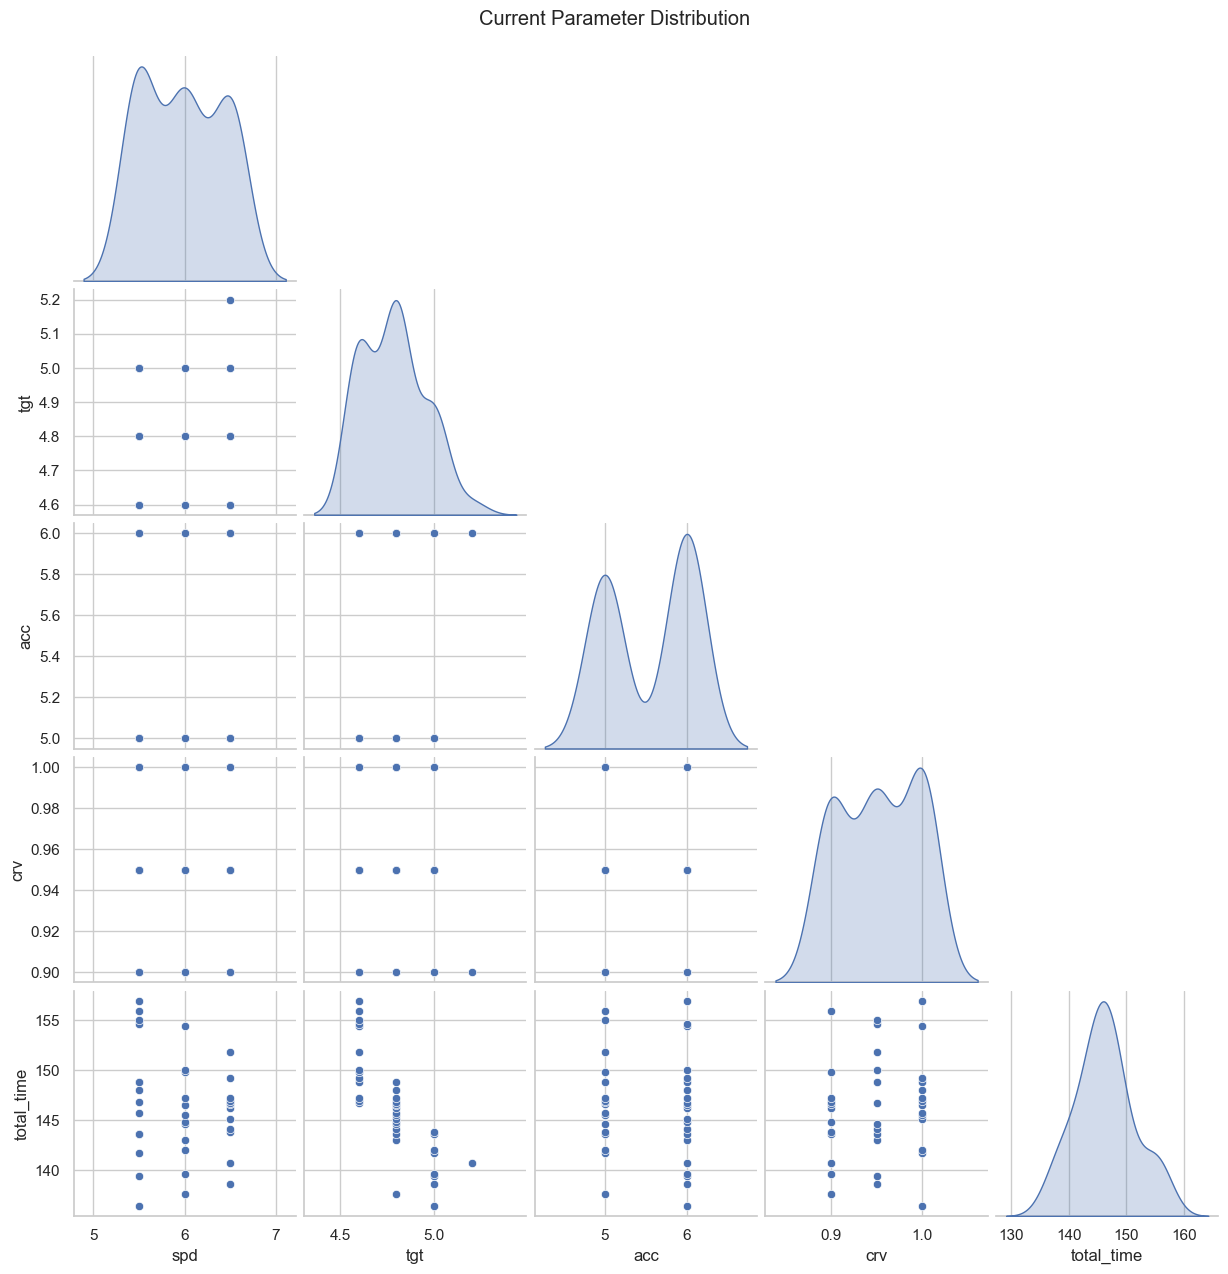

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# best_results(=complete_records)를 사용
if 'best_results' in locals() and not best_results.empty:
    # 인덱스 리셋하여 컬럼으로 변환
    vis_df = best_results.reset_index()
    
    # 보고 싶은 파라미터들
    cols_to_check = ['spd', 'tgt', 'acc', 'crv', 'total_time']
    
    # 페어플롯 그리기
    plt.figure(figsize=(10, 10))
    sns.pairplot(vis_df[cols_to_check], diag_kind='kde', corner=True)
    plt.suptitle("Current Parameter Distribution", y=1.02)
    plt.show()
else:
    print("시각화할 데이터가 없습니다.")